## 1. Importing the requisite packages

In [75]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot as gplt
import contextily

In [76]:
# Setting the data path
data_path = r'YOUR FILE PATH'

## 2. Creating Summary Spatial Features - One Dataset

In [77]:
# Reading in the data from the path
locs_pdf = pd.read_csv(data_path + 'OSM_DollarGeneralLocs.csv')

# Converting the pandas dataframe into a geopandas geodataframe
locs_gdf = gpd.GeoDataFrame(
    locs_pdf, geometry=gpd.points_from_xy(locs_pdf.X, locs_pdf.Y),
    crs="EPSG:4326"
)

# Resetting the index and creating a synthetic ID field
locs_gdf.reset_index(inplace=True)
locs_gdf.rename(columns={'index':'ID'}, inplace=True)

In [86]:
# To create a buffer, we first need to convert from a g-crs to a p-crs
locs_gdf = locs_gdf.to_crs(3005)

# Next, create aggregation area around each store
buffer_size_mi = 5
buffer_size_m = buffer_size_mi * 1609.344 # meters in a mile

# Creating a copy of the original dataframe to operate on
locs_gdf_buffer = locs_gdf.copy()

# Performing the buffer operation
locs_gdf_buffer["buffer_5mi"] = locs_gdf.buffer(buffer_size_m)

locs_gdf_buffer[['ID','geometry','X','Y','buffer_5mi']].head()

,ID,geometry,X,Y,buffer_5mi
0,0,POINT (4662241.144 445480.319),-82.458599,38.428581,"POLYGON ((4670287.864 445480.319, 4670249.117 ..."
1,1,POINT (4667682.555 450628.186),-82.375886,38.438389,"POLYGON ((4675729.275 450628.186, 4675690.528 ..."
2,2,POINT (4610865.116 491258.202),-82.633850,39.047795,"POLYGON ((4618911.836 491258.202, 4618873.089 ..."
3,3,POINT (4562888.418 588383.044),-82.443563,40.034121,"POLYGON ((4570935.138 588383.044, 4570896.391 ..."
4,4,POINT (4519081.302 666962.782),-82.332066,40.856058,"POLYGON ((4527128.022 666962.782, 4527089.275 ..."


In [79]:
# Joining the buffer to the store locations table
joined = gpd.sjoin(
    
    # Right table is the raw store locations data
    locs_gdf,
    # Left table is that of the buffers around the stores
    locs_gdf_buffer.set_geometry("buffer_5mi")[["ID", "buffer_5mi"]],
    # The operation, or spatial predicate, you'll use is `within`
    predicate="within"
)

In [80]:
# store count
store_count = (
    joined.groupby(
        "ID_left"
    )
    .count()
)

# Converting to a dataframe and cleaning up
store_count_df = store_count.reset_index()
store_count_df = store_count_df[['ID_left','ID_right']]
store_count_df.columns=['ID','Store_Count']

store_count_df.head()

,ID,Store_Count
0,0,2
1,1,2
2,2,1
3,3,1
4,4,1


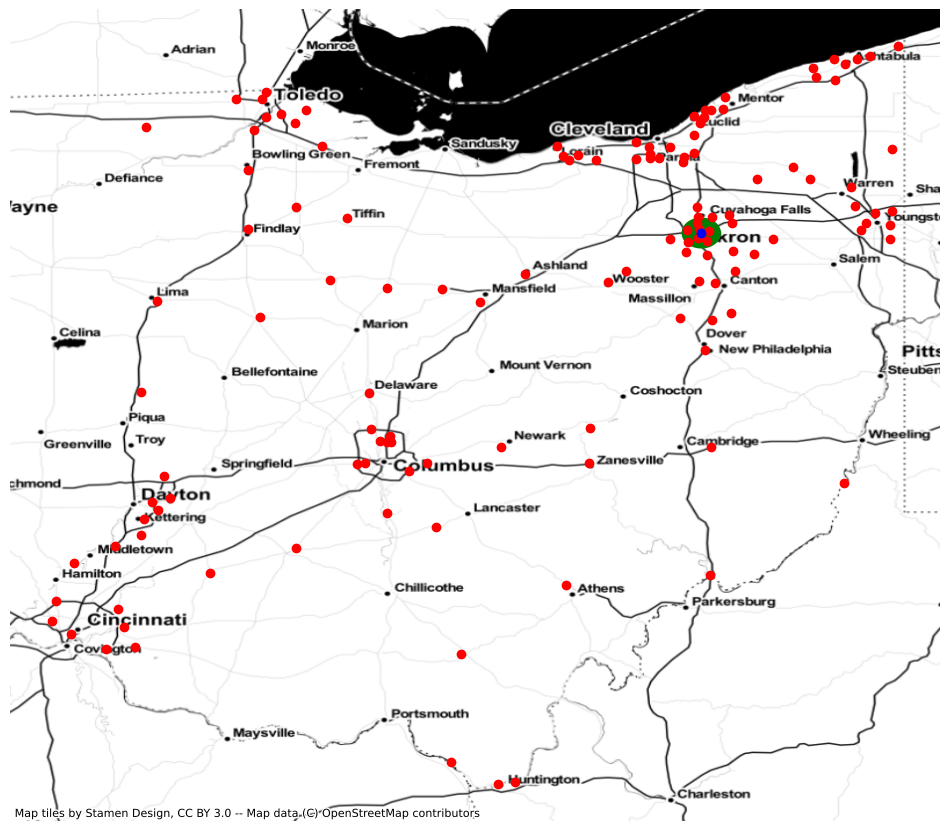

In [85]:
# Changing CRS to make mapping cleaner
locs_gdf_buffer = locs_gdf_buffer.set_geometry("buffer_5mi")[["ID", "buffer_5mi"]]
locs_gdf_buffer = locs_gdf_buffer.to_crs(4326)
locs_gdf = locs_gdf.to_crs(4326)

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))

# Plot Buffer around Store ID 45 in green
locs_gdf_buffer[locs_gdf_buffer['ID']==45].plot(ax=ax,color="g")

# Plot all stores in red
locs_gdf.plot(ax=ax, color="r")

# Plot store ID 2 in blue
locs_gdf[locs_gdf['ID']==45].plot(ax=ax,color="b")

# Add Stamen's Toner basemap
contextily.add_basemap(
    ax,
    crs=locs_gdf.crs.to_string(),
    source=contextily.providers.Stamen.Toner,
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

## 3. Creating Summary Spatial Features - Two Dataset

In [89]:
# Reading in the file
c_pdf = pd.read_csv(data_path + 'OSM_FamilyDollarLocs.csv')
# Converting the pandas dataframe into a geopandas geodataframe
c_gdf = gpd.GeoDataFrame(
    c_pdf, geometry=gpd.points_from_xy(c_pdf.X, c_pdf.Y), crs = "EPSG:4326"
)
# Converting to a p-CRS
c_gdf = c_gdf.to_crs(3005)
# Dropping records without valid geometries
c_gdf = c_gdf[~(c_gdf['geometry'].is_empty | c_gdf['geometry'].isna())]

In [90]:
# Reseting the index and creating a synthetic ID field
c_gdf.reset_index(inplace=True)
c_gdf.rename(columns={'index':'ID'}, inplace=True)
# Cleaning up the data to just being those stores in Ohio
Ohio = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2021/STATE/tl_2021_us_state.zip")
Ohio = Ohio[Ohio['STUSPS']=="OH"]
Ohio = Ohio.to_crs(3005)
c_gdf = gpd.overlay(c_gdf, Ohio, how='intersection')

In [91]:
# Changing to a p-crs for the buffer file
locs_gdf_buffer = locs_gdf_buffer.to_crs(3005)
# Joining the buffer to the store locations table
joined = gpd.sjoin(   
    # Right table is the competitor stores
    c_gdf,
    # Left table is that of the buffers around the primary company's Stores
    locs_gdf_buffer.set_geometry("buffer_5mi")[["ID", "buffer_5mi"]],
    # The operation, or spatial predicate, you'll use is `within`
    predicate="within"
)

In [92]:
# store count
store_count = (
    joined.groupby(
        "ID_left"
    )
    .count()
)
# Converting to a dataframe and cleaning up
store_count_df = store_count.reset_index()
store_count_df = store_count_df[['ID_left','ID_right']]
store_count_df.columns=['ID','Comp_Store_Count']
# Displaying the data
store_count_df.head()

,ID,Comp_Store_Count
0,0,1
1,2,1
2,7,3
3,8,4
4,9,1


## 4. Creating Proximity Spatial Features - NY Airbnb Dataset
We'll now turn our attention back to the NYC Airbnb Dataset to calculate proximity spatial features

In [49]:
# Reading in the data
listings = pd.read_csv(data_path + r'NY Airbnb June 2020\listings.csv.gz', compression='gzip', low_memory=False)

# Converting it to a GeoPandas DataFrame
listings_gpdf = gpd.GeoDataFrame(
    listings,
    geometry=gpd.points_from_xy(listings['longitude'],
                                   listings['latitude'],
                                   crs="EPSG:4326")
)

In [50]:
# Focusing on attractions in Manhattan, so we need to create a mask to filter locations 
# in the Manhattan borough
boroughs = gpd.read_file(data_path + r"NYC Boroughs\nybb_22a\nybb.shp")
manhattan = boroughs[boroughs['BoroName']=='Manhattan']
manhattan = manhattan.to_crs('EPSG:4326')

In [51]:
# Creating a mask
listings_mask = listings_gpdf.within(manhattan.loc[3, 'geometry'])
# Using the mask to filter the data
listings_manhattan = listings_gpdf.loc[listings_mask]
listings_manhattan.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,2595,https://www.airbnb.com/rooms/2595,20220603182654,2022-06-04,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,4.86,4.41,NaN,f,3,3,0,0,0.31,POINT (-73.98559 40.75356)
3,5178,https://www.airbnb.com/rooms/5178,20220603182654,2022-06-04,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,...,4.87,4.39,NaN,f,1,0,1,0,3.37,POINT (-73.98317 40.76457)
4,5203,https://www.airbnb.com/rooms/5203,20220603182654,2022-06-03,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,https://a0.muscache.com/pictures/103776/b37157...,7490,https://www.airbnb.com/users/show/7490,...,4.94,4.92,NaN,f,1,0,1,0,0.76,POINT (-73.96751 40.80380)
5,5295,https://www.airbnb.com/rooms/5295,20220603182654,2022-06-03,Beautiful 1br on Upper West Side,<b>The space</b><br />Beautiful 1br on the Upp...,NaN,https://a0.muscache.com/pictures/17395/dfed075...,7702,https://www.airbnb.com/users/show/7702,...,4.75,4.70,NaN,f,2,2,0,0,0.35,POINT (-73.96387 40.80316)
8,6872,https://www.airbnb.com/rooms/6872,20220603182654,2022-06-04,Uptown Sanctuary w/ Private Bath (Month to Month),A charming month-to-month home away from home ...,This sweet Harlem sanctuary is a 10-20 minute ...,https://a0.muscache.com/pictures/miso/Hosting-...,16104,https://www.airbnb.com/users/show/16104,...,NaN,NaN,NaN,f,2,0,2,0,NaN,POINT (-73.94255 40.80107)


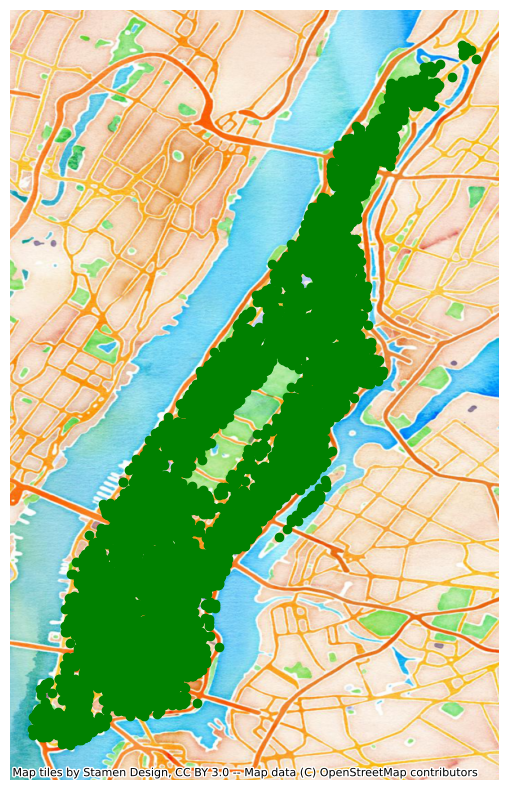

In [52]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot all airbnb locations in green
listings_manhattan.plot(ax=ax, color="g")

# Add Stamen's Toner basemap
contextily.add_basemap(
    ax,
    crs=listings_manhattan.crs.to_string(),
    source=contextily.providers.Stamen.Watercolor
)

# Remove axes
ax.set_axis_off()

# Display
plt.show()

In [59]:
# Reading in data on popular NYC Attractions
nyc_attr = pd.read_csv(data_path + 'NYC Attractions\\NYC Attractions.csv')
# Convert PDF to GPDF
nyc_attr_gpdf =  gpd.GeoDataFrame(
    nyc_attr,
    geometry=gpd.points_from_xy(nyc_attr['Longitude'],
                                   nyc_attr['Latitude'],
                                   crs="EPSG:4326")
)
# Displaying the top 5 rows of the table
nyc_attr_gpdf.head()

,Attraction,Latitude,Longitude,geometry
0,Central Park,40.7851,-73.9683,POINT (-73.96830 40.78510)
1,Central Park Zoo,40.7678,-73.9718,POINT (-73.97180 40.76780)
2,Empire State Building,40.7484,-73.9857,POINT (-73.98570 40.74840)
3,Statue of Liberty,40.6892,-74.0445,POINT (-74.04450 40.68920)
4,Rockeffeller Center,40.7587,-73.9787,POINT (-73.97870 40.75870)


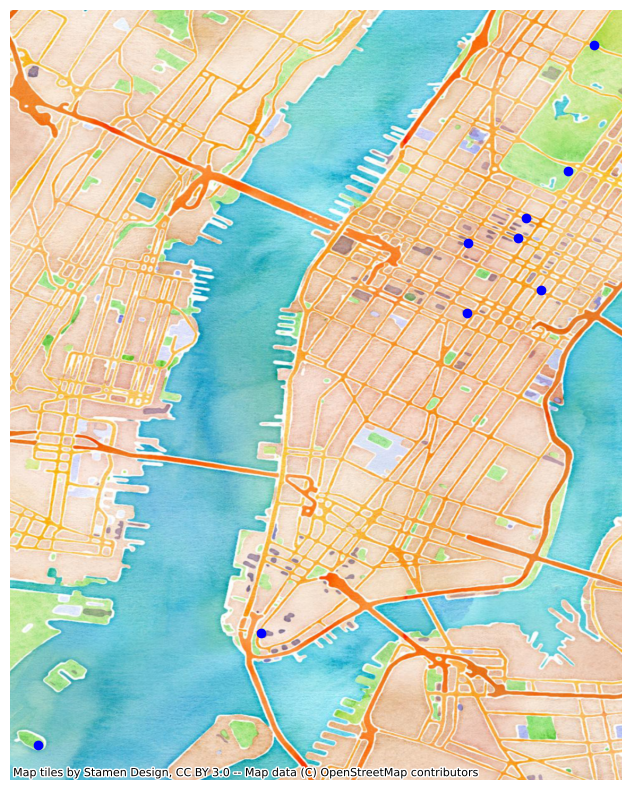

In [8]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot all attractions in blue
nyc_attr_gpdf.plot(ax=ax, color="b")
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax,
    crs=nyc_attr_gpdf.crs.to_string(),
    source=contextily.providers.Stamen.Watercolor
)
# Remove axes
ax.set_axis_off()
# Display the plot
plt.show()

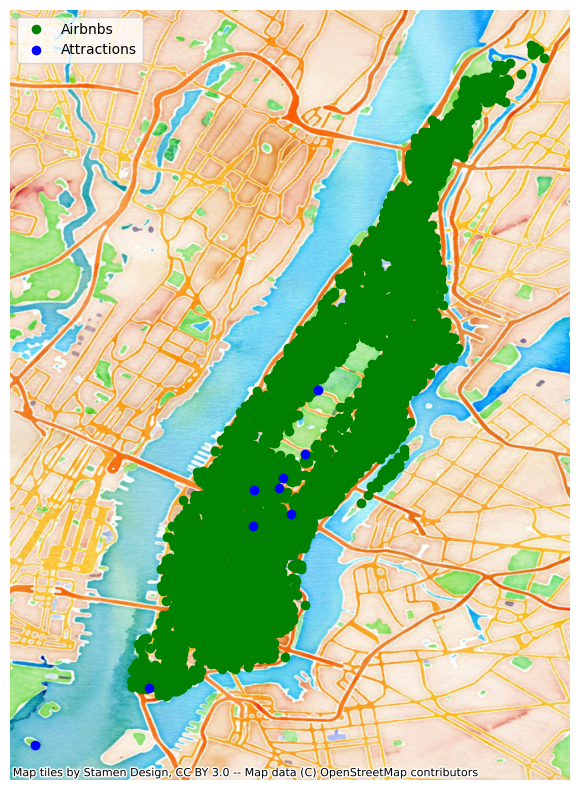

In [67]:
from matplotlib.lines import Line2D
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot all airbnb locations in green
listings_manhattan.plot(ax=ax, color="g")
# Plot all attractions in blue
nyc_attr_gpdf.plot(ax=ax, color="b")
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax,
    crs=nyc_attr_gpdf.crs.to_string(),
    source=contextily.providers.Stamen.Watercolor
)

# Remove axes
ax.set_axis_off()
# Manually creating a legend to orient audience
green_circle = Line2D([0], [0], marker='o', color='w', label='Airbnbs',
                        markerfacecolor='g', markersize=8)
blue_circle = Line2D([0], [0], marker='o', color='w', label='Attractions',
                        markerfacecolor='b', markersize=8)
plt.legend(handles=[green_circle, blue_circle])
# Display
plt.show()

In [69]:
# Calculate the distance to each attraction per airbnb
attractions = nyc_attr_gpdf.Attraction.unique()
# Converting to a projected coordinate system
nyc_attr_gpdf_p = nyc_attr_gpdf.to_crs('EPSG:2263')
listings_manhattan_p = listings_manhattan.to_crs('EPSG:2263')
# Applying a lambda function that calls geopandas distance function to calcuate the distance between each airbnb and each attraction
distances = listings_manhattan_p.geometry.apply(lambda g: nyc_attr_gpdf_p.distance(g)).head()
# Renaming the columns based on the attraction for which the distance is calculated
distances.columns = attractions
# Displaying the top 5 rows of the dataframe
distances.head()

,Central Park,Central Park Zoo,Empire State Building,Statue of Liberty,Rockeffeller Center,Chrysler Building,Times Square,MoMa,Charging Bull
0,12449.130062,6442.862187,1880.199860,28574.036112,2674.066939,2885.323549,1617.825078,3613.682993,19487.155574
3,8538.688680,3362.228580,5932.798876,32295.400375,2471.258560,5181.159022,2479.163838,1927.357948,23450.112153
4,6816.554618,13169.697177,20803.298480,46886.737387,16721.114119,19146.493310,17414.384906,15698.425821,38359.075319
5,6693.228881,13068.659750,20846.911385,47148.746689,16710.826727,19059.163990,17509.856678,15682.502983,38491.046003
8,9202.788412,14578.795940,22606.795834,49590.794162,18399.168241,20202.275236,19690.749451,17410.219618,40325.055534


In [70]:
# To understand what the distance unit is, we run the following function
listings_manhattan_p.crs.axis_info[0].unit_name

'US survey foot'

In [71]:
# Convert from 'US survey foot' to miles
distances = distances.apply(lambda x: x/5280, axis=1)
distances.head()

,Central Park,Central Park Zoo,Empire State Building,Statue of Liberty,Rockeffeller Center,Chrysler Building,Times Square,MoMa,Charging Bull
0,2.357790,1.220239,0.356098,5.411749,0.506452,0.546463,0.306406,0.684410,3.690749
3,1.617176,0.636786,1.123636,6.116553,0.468041,0.981280,0.469539,0.365030,4.441309
4,1.291014,2.494261,3.940019,8.880064,3.166878,3.626230,3.298179,2.973187,7.264976
5,1.267657,2.475125,3.948279,8.929687,3.164929,3.609690,3.316261,2.970171,7.289971
8,1.742952,2.761136,4.281590,9.392196,3.484691,3.826188,3.729309,3.297390,7.637321


In [72]:
# Check to see which locations are less than 2 miles

distances_1mi = distances.apply(lambda x: x <=1, axis=1).sum(axis=1)
distances_2mi = distances.apply(lambda x: x <=2, axis=1).sum(axis=1)
distances_3mi = distances.apply(lambda x: x <=3, axis=1).sum(axis=1)
distances_4mi = distances.apply(lambda x: x <=4, axis=1).sum(axis=1)
distances_5mi = distances.apply(lambda x: x <=5, axis=1).sum(axis=1)
distances_6mi = distances.apply(lambda x: x <=6, axis=1).sum(axis=1)

# Creating a dataframe combining all the distance bands
distance_df = pd.concat([distances_1mi,distances_2mi,distances_3mi,distances_4mi,distances_5mi,distances_6mi], axis=1)
distance_df.columns = ['Attr_1mi','Attr_2mi','Attr_3mi','Attr_4mi','Attr_5mi','Attr_6mi']
distance_df.head()

,Attr_1mi,Attr_2mi,Attr_3mi,Attr_4mi,Attr_5mi,Attr_6mi
0,5,6,7,8,8,9
3,5,7,7,7,8,8
4,0,1,3,7,7,7
5,0,1,3,7,7,7
8,0,1,2,6,7,7


In [73]:
# Joining back to the listings geopandas df
listings_manhattan = listings_manhattan.merge(distances, left_index=True, right_index=True)
listings_manhattan = listings_manhattan.merge(distance_df, left_index=True, right_index=True)

#listings_manhattan.head()

In [74]:
listings_manhattan.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,Chrysler Building,Times Square,MoMa,Charging Bull,Attr_1mi,Attr_2mi,Attr_3mi,Attr_4mi,Attr_5mi,Attr_6mi
0,2595,https://www.airbnb.com/rooms/2595,20220603182654,2022-06-04,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,0.546463,0.306406,0.684410,3.690749,5,6,7,8,8,9
3,5178,https://www.airbnb.com/rooms/5178,20220603182654,2022-06-04,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,...,0.981280,0.469539,0.365030,4.441309,5,7,7,7,8,8
4,5203,https://www.airbnb.com/rooms/5203,20220603182654,2022-06-03,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,https://a0.muscache.com/pictures/103776/b37157...,7490,https://www.airbnb.com/users/show/7490,...,3.626230,3.298179,2.973187,7.264976,0,1,3,7,7,7
5,5295,https://www.airbnb.com/rooms/5295,20220603182654,2022-06-03,Beautiful 1br on Upper West Side,<b>The space</b><br />Beautiful 1br on the Upp...,NaN,https://a0.muscache.com/pictures/17395/dfed075...,7702,https://www.airbnb.com/users/show/7702,...,3.609690,3.316261,2.970171,7.289971,0,1,3,7,7,7
8,6872,https://www.airbnb.com/rooms/6872,20220603182654,2022-06-04,Uptown Sanctuary w/ Private Bath (Month to Month),A charming month-to-month home away from home ...,This sweet Harlem sanctuary is a 10-20 minute ...,https://a0.muscache.com/pictures/miso/Hosting-...,16104,https://www.airbnb.com/users/show/16104,...,3.826188,3.729309,3.297390,7.637321,0,1,2,6,7,7
